In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import io
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import pdb
import matplotlib
import matplotlib.pyplot as plt

BATCH_SIZE = 32
VOCAB_SIZE = 50000

In [4]:
# nltk.download('punkt')

### Helper functions for each step in the pipeline

In [5]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    print(n, d)
    i = 0
    for line in fin:
        if i == VOCAB_SIZE:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
        i += 1
    return data

In [6]:
from collections import Counter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
VOCAB_SIZE = 50000

def build_vocab():
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    word_vectors = pkl.load(open("fasttext_word_vectors.p", "rb"))
    id2token = list(word_vectors.keys())
    token2id = dict(zip(word_vectors, range(2,2+len(word_vectors)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return word_vectors, token2id, id2token

In [7]:
def convert_labels_to_integers(data_label):
    for i in range(len(data_label)):
        if data_label[i] == "contradiction":
            data_label[i] = 0
        elif data_label[i] == "entailment":
            data_label[i] = 1
        elif data_label[i] == "neutral":
            data_label[i] = 2
    return data_label

In [8]:
def verify_order(sent1_data, sent2_data, data_label):
    i = random.randint(1, len(sent1_data))
    print(sent1_data[i])
    print(sent2_data[i])
    print(data_label[i])

In [9]:
# Word tokenize each entry in a list of sentences
def tokenize(sentence_list):
    return [word_tokenize(sentence_list[i]) for i in range(len(sentence_list))]

In [10]:
# "one-hot encode": convert each token to id in vocabulary vector (token2id)
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data 

### Creating vocabulary & embedding matrix from FastText vectors

In [11]:
word_vectors, token2id, id2token = build_vocab()

In [12]:
_weights = np.array(list(word_vectors.values()))
pad_vec = np.zeros((1, 300))
unk_vec = np.random.randn(1, 300) * 0.01
pad_unk_vecs = np.vstack((pad_vec, unk_vec))
_WEIGHTS = np.vstack((pad_unk_vecs, _weights))
_WEIGHTS.shape

(50002, 300)

### Function to pre-process data for TwoSentenceModel
#### Shuffle, word tokenize, one-hot index into vocabulary

In [13]:
def data_pipeline(sent1s, sent2s, labels, verify=True):
    labels = convert_labels_to_integers(labels)
    seed = random.randint(1, 100)
    print("Random seed for shuffling: {}".format(seed))
    random.Random(seed).shuffle(sent1s)
    random.Random(seed).shuffle(sent2s)
    random.Random(seed).shuffle(labels)
    
    print("\nVerifying that the data and label match after shuffling")
    if verify:
        verify_order(sent1s, sent2s, labels)
        verify_order(sent1s, sent2s, labels)
          
    print("\nTokenizing sentence 1 list...")    
    sent1s_tokenized = tokenize(sent1s)
    print("done!")
    print("\nTokenizing sentence 2 list... ")  
    sent2s_tokenized = tokenize(sent2s)
    print("done!")
    
    print("\nOne-hot encoding words for sentence 1 list...")  
    sent1s_indices = token2index_dataset(sent1s_tokenized)
    print("done!")
    print("\nOne-hot encoding words for sentence 2 list...")  
    sent2s_indices = token2index_dataset(sent2s_tokenized)
    print("done!")
    
    return (sent1s_indices, sent2s_indices, labels)

### DataLoader

In [14]:
# MAX_SENTENCE_LENGTH = 30

import numpy as np
import torch
from torch.utils.data import Dataset

class TwoSentencesDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    """
    
    def __init__(self, sent1_data_list, sent2_data_list, target_list):
        """
        @param sent1_data_list: list of sentence1's (index matches sentence2's and target_list below)
        @param sent2_data_list: list of sentence2's
        @param target_list: list of correct labels

        """
        self.sent1_data_list = sent1_data_list
        self.sent2_data_list = sent2_data_list
        self.target_list = target_list
        assert (len(self.sent1_data_list) == len(self.target_list) and len(self.sent2_data_list) == len(self.target_list))

    def __len__(self):
        return len(self.sent1_data_list)
        
    def __getitem__(self, key):
        ###
        ### Returns [[sentence, 1, tokens], [sentence, 2, tokens]]
        ###
        """
        Triggered when you call dataset[i]
        """
        sent1_tokens_idx = self.sent1_data_list[key][:MAX_SENTENCE_LENGTH]
        sent2_tokens_idx = self.sent2_data_list[key][:MAX_SENTENCE_LENGTH]
        combined_tokens_idx = [sent1_tokens_idx, sent2_tokens_idx]
        label = self.target_list[key]
        return [combined_tokens_idx, len(sent1_tokens_idx), len(sent2_tokens_idx), label]

def twosentences_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sent1_data_list = []
    sent2_data_list = []
    sent1_length_list = []
    sent2_length_list = []
    label_list = []
    combined_data_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[3])
        sent1_length_list.append(datum[1])
        sent2_length_list.append(datum[2])
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0][0]), pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        padded_vec_2 = np.pad(np.array(datum[0][1]), pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        combined_data_list.append([padded_vec_1, padded_vec_2])
    return [torch.from_numpy(np.array(combined_data_list)), 
            torch.LongTensor(sent1_length_list), torch.LongTensor(sent2_length_list), torch.LongTensor(label_list)]

### Train Dataset creation

In [15]:
snli_train = pd.read_csv('snli_train.tsv', sep='\t')
TRAIN_SIZE = 100000

sent1_data = list(snli_train["sentence1"])[:TRAIN_SIZE]
sent2_data = list(snli_train["sentence2"])[:TRAIN_SIZE]
data_label = list(snli_train["label"])[:TRAIN_SIZE]
print("Size of training data: {}".format(len(sent1_data)))

Size of training data: 100000


In [16]:
sent1_train_indices, sent2_train_indices, train_label = data_pipeline(sent1_data, sent2_data, data_label)
train_dataset = TwoSentencesDataset(sent1_train_indices, sent2_train_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )
print("Finished creating train_loader.")

Random seed for shuffling: 77

Verifying that the data and label match after shuffling
A few people are packing food into containers and boxes .
People are packing food .
1
A man wearing a Chinese flag sits on a stone monument and plays the banjo .
A man plays a guitar while he rollerskates .
0

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!
Finished creating train_loader.


### Val Dataset creation

In [17]:
snli_val = pd.read_csv('snli_val.tsv', sep='\t')
sent1_val = list(snli_val["sentence1"])
sent2_val = list(snli_val["sentence2"])
val_label = list(snli_val["label"])
print("Size of val data: {}".format(len(sent1_val)))

Size of val data: 1000


In [18]:
sent1_val_indices, sent2_val_indices, val_label = data_pipeline(sent1_val, sent2_val, val_label)
val_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )

Random seed for shuffling: 47

Verifying that the data and label match after shuffling
Two young girls looking at Barbie dolls .
A girl and a boy are running with toys .
0
A young boy wearing safety swimming gear and goggles is in a pool .
A family of four plays in the surf .
0

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!


In [19]:
pd.Series([len(x) for x in snli_train['sentence1']]).describe()['75%']
MAX_SENTENCE_LENGTH = 40

### CNN Model

In [80]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(_WEIGHTS))
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(30)
        self.linear1 = nn.Linear(2*hidden_size, 100)
        self.linear2 = nn.Linear(100, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, sent1_lengths, sent2_lengths):
        
        batch_size = x.size()[0]
        seq_len = x.size()[2]
        
        sent1s = torch.tensor(x[:, 0, :]).cuda()
        sent2s = torch.tensor(x[:, 1, :]).cuda()
        ordered_sents = torch.cat([sent1s, sent2s], dim=0).cuda()

        embed = self.embedding(ordered_sents)
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(2*batch_size, seq_len, hidden.size(-1))

        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(2*batch_size, seq_len, hidden.size(-1))
        hidden = self.maxpool(hidden.transpose(1, 2)).transpose(1, 2).squeeze(dim=1)
        
        hidden_sent1s = hidden[0:batch_size, :]
        hidden_sent2s = hidden[batch_size:, :]     
        
        linear1 = self.linear1(torch.cat([hidden_sent1s, hidden_sent2s], dim=1))
#         linear1 = self.linear1(torch.tensor(hidden_sent1s) + torch.tensor(hidden_sent2s))
#         linear1 = self.linear1(torch.tensor(hidden_sent1s)*torch.tensor(hidden_sent2s))
        linear1 = F.relu(linear1.contiguous().view(-1, linear1.size(-1))).view(linear1.shape)
#         linear1 = self.dropout(linear1)
        logits = self.linear2(linear1)
        
        return logits

In [21]:
a = torch.randn(3, 4)
b = torch.randn(3, 4)
print(a)
print(b)
print(a*b)

tensor([[-0.8704, -0.7408, -0.3186, -1.2397],
        [ 0.9380,  0.4863, -0.6737,  0.1046],
        [ 0.4451, -1.6797, -1.1978, -1.1759]])
tensor([[ 1.7090,  1.4949, -0.0816,  1.6153],
        [-0.0372, -0.5010, -0.4593, -0.2813],
        [-0.6716,  0.2631,  1.0884, -0.3128]])
tensor([[-1.4875, -1.1074,  0.0260, -2.0025],
        [-0.0349, -0.2437,  0.3095, -0.0294],
        [-0.2989, -0.4419, -1.3037,  0.3678]])


In [73]:
# Function for testing the model
def test_model(loader, model):
    """
    Helper function that tests the model's performance on a dataset
    """
    correct = 0
    total = 0
    model.eval()
    for (data, sent1_lengths, sent2_lengths, labels) in loader:
        data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.cuda(), sent1_lengths.cuda(), sent2_lengths.cuda(), labels.cuda()
        outputs = F.softmax(model(data_batch, sent1_length_batch, sent2_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.cuda()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model, lr = 0.001, num_epochs = 7, criterion = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    max_val_acc = 0
    losses = []
    xs = 0
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data, sent1_lengths, sent2_lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.cuda(), sent1_lengths.cuda(), sent2_lengths.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch, sent1_length_batch, sent2_length_batch)
            loss = criterion(outputs, label_batch)
            losses.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_accs.append(val_acc)
                xs += 100
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                print('Epoch: [{}/{}], Step: [{}/{}], Training Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss))
                
    print("Max Validation Accuracy: {}".format(max_val_acc))
    return max_val_acc, losses, xs, val_accs

### Plotting training (loss) and validation (accuracy) curves

In [74]:
def plot_loss_and_validation_curves(losses, xs, val_accs, title):
    fig = plt.figure(figsize=(4, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    loss_avg_vals = []
    for i in range(0, len(losses)-100, 100):
        s = 0
        avg = 0
        for j in range(i, i+100):
            s += losses[j]
        avg = s/100.0
        loss_avg_vals.append(avg)

    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_avg_vals)), loss_avg_vals)
    plt.xlabel('Step')
    plt.ylabel('Average Train Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, xs, 100), val_accs)
    plt.xlabel('Step')
    plt.ylabel('Val Acc')

In [75]:
model = CNN(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).cuda()
max_val_acc, losses, xs, val_accs = train_model(model)

Epoch: [1/7], Step: [101/3125], Validation Acc: 35.8
Epoch: [1/7], Step: [101/3125], Training Loss: 1.101027011871338
Epoch: [1/7], Step: [201/3125], Validation Acc: 36.3
Epoch: [1/7], Step: [201/3125], Training Loss: 1.0916448831558228
Epoch: [1/7], Step: [301/3125], Validation Acc: 37.7
Epoch: [1/7], Step: [301/3125], Training Loss: 1.1033012866973877
Epoch: [1/7], Step: [401/3125], Validation Acc: 38.6
Epoch: [1/7], Step: [401/3125], Training Loss: 1.0696437358856201
Epoch: [1/7], Step: [501/3125], Validation Acc: 41.5
Epoch: [1/7], Step: [501/3125], Training Loss: 1.0386451482772827
Epoch: [1/7], Step: [601/3125], Validation Acc: 41.8
Epoch: [1/7], Step: [601/3125], Training Loss: 1.074448585510254
Epoch: [1/7], Step: [701/3125], Validation Acc: 43.4
Epoch: [1/7], Step: [701/3125], Training Loss: 1.0154290199279785
Epoch: [1/7], Step: [801/3125], Validation Acc: 45.2
Epoch: [1/7], Step: [801/3125], Training Loss: 1.0488476753234863
Epoch: [1/7], Step: [901/3125], Validation Acc: 45

Epoch: [3/7], Step: [801/3125], Validation Acc: 62.0
Epoch: [3/7], Step: [801/3125], Training Loss: 0.621756374835968
Epoch: [3/7], Step: [901/3125], Validation Acc: 61.8
Epoch: [3/7], Step: [901/3125], Training Loss: 0.8702166080474854
Epoch: [3/7], Step: [1001/3125], Validation Acc: 61.3
Epoch: [3/7], Step: [1001/3125], Training Loss: 0.8829164505004883
Epoch: [3/7], Step: [1101/3125], Validation Acc: 62.0
Epoch: [3/7], Step: [1101/3125], Training Loss: 0.7650295495986938
Epoch: [3/7], Step: [1201/3125], Validation Acc: 60.8
Epoch: [3/7], Step: [1201/3125], Training Loss: 0.8357694745063782
Epoch: [3/7], Step: [1301/3125], Validation Acc: 60.6
Epoch: [3/7], Step: [1301/3125], Training Loss: 0.7405416369438171
Epoch: [3/7], Step: [1401/3125], Validation Acc: 61.4
Epoch: [3/7], Step: [1401/3125], Training Loss: 0.7267556190490723
Epoch: [3/7], Step: [1501/3125], Validation Acc: 60.2
Epoch: [3/7], Step: [1501/3125], Training Loss: 0.7373424172401428
Epoch: [3/7], Step: [1601/3125], Vali

Epoch: [5/7], Step: [1501/3125], Validation Acc: 61.1
Epoch: [5/7], Step: [1501/3125], Training Loss: 0.5832830667495728
Epoch: [5/7], Step: [1601/3125], Validation Acc: 61.4
Epoch: [5/7], Step: [1601/3125], Training Loss: 0.6622936129570007
Epoch: [5/7], Step: [1701/3125], Validation Acc: 60.4
Epoch: [5/7], Step: [1701/3125], Training Loss: 0.7139739990234375
Epoch: [5/7], Step: [1801/3125], Validation Acc: 61.4
Epoch: [5/7], Step: [1801/3125], Training Loss: 0.7312016487121582
Epoch: [5/7], Step: [1901/3125], Validation Acc: 62.2
Epoch: [5/7], Step: [1901/3125], Training Loss: 0.5293908715248108
Epoch: [5/7], Step: [2001/3125], Validation Acc: 61.1
Epoch: [5/7], Step: [2001/3125], Training Loss: 0.7708113789558411
Epoch: [5/7], Step: [2101/3125], Validation Acc: 62.2
Epoch: [5/7], Step: [2101/3125], Training Loss: 0.691259503364563
Epoch: [5/7], Step: [2201/3125], Validation Acc: 62.3
Epoch: [5/7], Step: [2201/3125], Training Loss: 0.6741315722465515
Epoch: [5/7], Step: [2301/3125], 

Epoch: [7/7], Step: [2201/3125], Validation Acc: 62.7
Epoch: [7/7], Step: [2201/3125], Training Loss: 0.5812860727310181
Epoch: [7/7], Step: [2301/3125], Validation Acc: 61.5
Epoch: [7/7], Step: [2301/3125], Training Loss: 0.8683007955551147
Epoch: [7/7], Step: [2401/3125], Validation Acc: 61.6
Epoch: [7/7], Step: [2401/3125], Training Loss: 0.7669524550437927
Epoch: [7/7], Step: [2501/3125], Validation Acc: 62.0
Epoch: [7/7], Step: [2501/3125], Training Loss: 0.4694633185863495
Epoch: [7/7], Step: [2601/3125], Validation Acc: 62.0
Epoch: [7/7], Step: [2601/3125], Training Loss: 0.5892811417579651
Epoch: [7/7], Step: [2701/3125], Validation Acc: 61.4
Epoch: [7/7], Step: [2701/3125], Training Loss: 0.6974173188209534
Epoch: [7/7], Step: [2801/3125], Validation Acc: 63.2
Epoch: [7/7], Step: [2801/3125], Training Loss: 0.698179304599762
Epoch: [7/7], Step: [2901/3125], Validation Acc: 62.3
Epoch: [7/7], Step: [2901/3125], Training Loss: 0.656996488571167
Epoch: [7/7], Step: [3001/3125], V

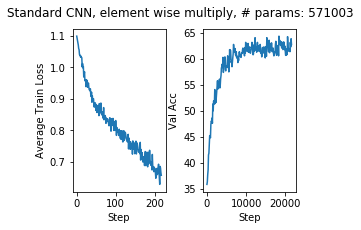

In [76]:
def get_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

plot_loss_and_validation_curves(losses, xs, val_accs, "Standard CNN, element wise multiply, # params: {}".format(get_trainable_parameters(model)))

In [62]:
# torch.save(model.state_dict(), "/home/vrajiv/rnn-cnn-natural-language-inference/best_cnn")

### Hyperparameter tuning

**Standard CNN** architecture and training hyperparameters: 2 Convolutional layers (each with kernel size 3) followed by 2 fully connected layers, hidden_size 300, 7 epochs, lr = 0.001. Used embedding layer with FastText vectors, with freeze = False. I've also included the results with freeze = True. 

| Hyperparameters changed                  | CNN (val accuracy) | RNN (val accuracy) |
|------------------------------------------|:------------------:|:------------------:|
| Standard, freeze=False                   |        67.5%       |        69.9%       |
| Standard, freeze=True                    |        67.2%       |        69.2%       |
| Hidden size: 400                         |        67.2%       |        70.0%       |
| Hidden size: 500                         |        67.1%       |        68.8%       |
| Dropout (p = 0.5)                        |        66.6%       |        68.9%       |
| Dropout (p = 0.2)                        |        67.2%       |        69.8%       |
| Interaction: sum                         |        62.2%       |        64.1%       |
| Interaction: element-wise multiplication |        65.8%       |        71.2%       |

### Evaluating on MNLI

In [63]:
mnli_val = pd.read_csv('mnli_val.tsv', sep='\t')

In [64]:
sentence_length_75 = pd.Series([len(x) for x in mnli_val['sentence1']]).describe()['75%']
print("75th percentile for sentence length (in characters): {}".format(sentence_length_75))
MAX_SENTENCE_LENGTH = 40

75th percentile for sentence length (in characters): 151.0


#### Build dictionary of (sent1, sent2, label) data, by genre.

In [65]:
mnli_val_dict = {}
for x in mnli_val['genre'].unique():
    filtered = mnli_val[mnli_val['genre'] == x]
    mnli_val_dict[x] = {}
    mnli_val_dict[x]["sent1s"] = list(filtered["sentence1"])
    mnli_val_dict[x]["sent2s"] = list(filtered["sentence2"])
    mnli_val_dict[x]["label"] = convert_labels_to_integers(list(filtered["label"]))

In [66]:
for x in mnli_val_dict.keys():
    print(len(mnli_val_dict[x]["sent1s"]))
    print(np.unique(mnli_val_dict[x]["label"]))
    
# quick verify
verify_order(mnli_val_dict['travel']["sent1s"], mnli_val_dict['travel']["sent2s"], mnli_val_dict['travel']["label"])

995
[0 1 2]
1005
[0 1 2]
1002
[0 1 2]
1016
[0 1 2]
982
[0 1 2]
France knew a good thing when she seized one , but then so did Britain .
France knew this was a good place to stay .
2


In [67]:
# for each genre, build validation set and evaluate on it. 
cnn_results = {}
model = CNN(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).cuda()
model.load_state_dict(torch.load("/home/vrajiv/rnn-cnn-natural-language-inference/best_cnn"))
model.eval()
for genre in mnli_val_dict.keys():
    sent1_val_indices, sent2_val_indices, val_label = data_pipeline(mnli_val_dict[genre]["sent1s"], 
                                                                    mnli_val_dict[genre]["sent2s"], 
                                                                    mnli_val_dict[genre]["label"])
    val_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=BATCH_SIZE, 
                                             collate_fn=twosentences_collate_func,
                                             #shuffle=True
                                             )
    cnn_results[genre] = test_model(val_loader, model)

for genre in mnli_val_dict.keys():
    print("Genre {} has validation accuracy: {}".format(genre, cnn_results[genre]))
    

Random seed for shuffling: 45

Verifying that the data and label match after shuffling
No , do n't answer .
Please respond .
0
Then I considered .
Then , I thought if I should accepted to go with him .
2

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!
Random seed for shuffling: 58

Verifying that the data and label match after shuffling
but how do you know the good from the bad
Why care if it 's good or bad ?
0
so i guess my experience is is just with what we did and and so they did n't really go through the child care route they were able to be home together
It was a good thing that they did n't go the child care route as they were able to be home with their child more often .
2

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
don

### MNLI results

| genre      | CNN (val accuracy) | RNN (val accuracy) |
|------------|--------------------|--------------------|
| fiction    |       42.31%       |       45.53%       |
| telephone  |       43.58%       |       40.40%       |
| travel     |       42.57%       |       41.65%       |
| slate      |       41.62%       |       40.52%       |
| government |       39.76%       |       41.43%       |

### 3 correct and 3 incorrect predictions

In [81]:
model = CNN(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).cuda()
model.load_state_dict(torch.load("/home/vrajiv/rnn-cnn-natural-language-inference/best_cnn"))
model.eval()

eval_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
eval_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=1, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )

i = 0
incorrect_data = []
correct_data = []
corr_count = 0
incorr_count = 0
for data, sent1_lengths, sent2_lengths, labels in eval_loader:
        data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.cuda(), sent1_lengths.cuda(), sent2_lengths.cuda(), labels.cuda()
        outputs = F.softmax(model(data_batch, sent1_length_batch, sent2_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.cuda()
        
        if (predicted.squeeze().item() == labels.squeeze().item() and corr_count <= 2):
            corr_count += 1
            correct_data.append(snli_val.iloc[[i]])
            print("correct: ", labels.squeeze().item())
        elif (predicted.squeeze().item() != labels.squeeze().item() and incorr_count <= 2):
            incorr_count += 1
            incorrect_data.append(snli_val.iloc[[i]])
            print("incorrect: ", labels.squeeze().item())
        i += 1
        
        if corr_count == 3 and incorr_count == 3:
            break       

correct:  1
incorrect:  0
correct:  2
incorrect:  2
incorrect:  1
correct:  0


In [82]:
for i in range(len(correct_data)):
    print(correct_data[i]["sentence1"])
    print(correct_data[i]["sentence2"])
    print(correct_data[i]["label"])
    print("\n\n")

0    Three women on a stage , one wearing red shoes...
Name: sentence1, dtype: object
0    There are two women standing on the stage
Name: sentence2, dtype: object
0    contradiction
Name: label, dtype: object



2    bicycles stationed while a group of people soc...
Name: sentence1, dtype: object
2    People get together near a stand of bicycles .
Name: sentence2, dtype: object
2    entailment
Name: label, dtype: object



6    Two men are listening to music through headpho...
Name: sentence1, dtype: object
6    Two men listen to music .
Name: sentence2, dtype: object
6    entailment
Name: label, dtype: object





In [83]:
for i in range(len(incorrect_data)):
    print(incorrect_data[i]["sentence1"])
    print(incorrect_data[i]["sentence2"])
    print(incorrect_data[i]["label"])
    print("\n\n")

1    Four people sit on a subway two read books , o...
Name: sentence1, dtype: object
1    Multiple people are on a subway together , wit...
Name: sentence2, dtype: object
1    entailment
Name: label, dtype: object



3    Man in overalls with two horses .
Name: sentence1, dtype: object
3    a man in overalls with two horses
Name: sentence2, dtype: object
3    entailment
Name: label, dtype: object



4    Man observes a wavelength given off by an elec...
Name: sentence1, dtype: object
4    The man is examining what wavelength is given ...
Name: sentence2, dtype: object
4    entailment
Name: label, dtype: object





The CNN model seems to be good at associating numbers of objects to each other, either for contradiction or entailment purposes. It does not seem to effectively learn how sentences can be structured differently but give the same meaning. 